In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from vega_datasets import data

In [2]:
df = pd.read_csv('student-mat.csv')

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


# Final project for DS 2.1 - Machine Learning - Andrey Novichkov
## Dataset - Student Alcahol Consumption (Kaggle)

**Questions I want to Answer:**
- What are the trends amongs male vs female students
- What are the overall correlations between the different features?
- See if Alcahol consumption affects final grades!
- What is the one feature that is the best predictor for the final grade(random forest)
- Build linear regression model that predicts grades
- Build classification models that predict pass/fail of a student
- PCA to try improve models

In [4]:
df.shape

(395, 33)

In [5]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

## 395 samples  
## 33 features: 
> 'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'

In [6]:
feature_cols_small = ['sex', 'age', 'studytime', 'failures', 'goout', 'Dalc', 'Walc', 'absences', 'G3']
feature_cols_big = ['sex', 'age', 'studytime', 'failures', 'goout', 'Dalc', 'Walc', 'absences', 'romantic', 'famrel', 'health', 'G1', 'G2', 'G3']

## Let's get some general stats and explore the data

**Decided to look at these features:**  
> 'sex', 'age', 'studytime', 'failures', 'goout', 'Dalc', 'Walc', 'absences', 'G3'

In [7]:
sml_feature_df = df[feature_cols_small]
males = sml_feature_df[sml_feature_df['sex'] == 'M']
females = sml_feature_df[sml_feature_df['sex'] == 'F']

In [8]:
sml_feature_df[:2]

,sex,age,studytime,failures,goout,Dalc,Walc,absences,G3
0,F,18,2,0,4,1,1,6,6
1,F,17,2,0,3,1,1,4,6


In [9]:
male_means = males.mean()
d = {
    'feature': male_means.index,
    'average': male_means.values
}
male_df = pd.DataFrame(d)
male_df['sex'] = 'male'

female_means = females.mean()
d = {
    'feature': female_means.index,
    'average': female_means.values
}
female_df = pd.DataFrame(d)
female_df['sex'] = 'female'

avg_feature_df = pd.concat([female_df, male_df])

In [10]:
alt.Chart(avg_feature_df).mark_bar().encode(
    x='sex:O',
    y='average:Q',
    color='sex:O',
    column='feature:O'
)

alt.Chart(...)

In [11]:
chart = alt.Chart(sml_feature_df).transform_fold(
    ['Dalc',
     'Walc',
     'goout',
     'studytime',
     'failures'],
    as_ = ['Features', 'value']
).transform_density(
    density='value',
    bandwidth=0.3,
    groupby=['Features'],
    extent= [0, 5]
).mark_area().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('Features:N')
).properties(width=500, height=50)

In [12]:
chart

alt.Chart(...)

In [13]:
grade_df = df[['G1', 'G2', 'G3']]
grade_df[:2]

,G1,G2,G3
0,5,6,6
1,5,5,6


In [14]:
alt.Chart(grade_df).mark_circle(size=60).encode(
    x='G3',
    y='G2',
    color='G1'
)

alt.Chart(...)

## Do we have correlation among features?

In [15]:
plt.gcf().set_size_inches(11.7, 8.27)

<Figure size 842.4x595.44 with 0 Axes>

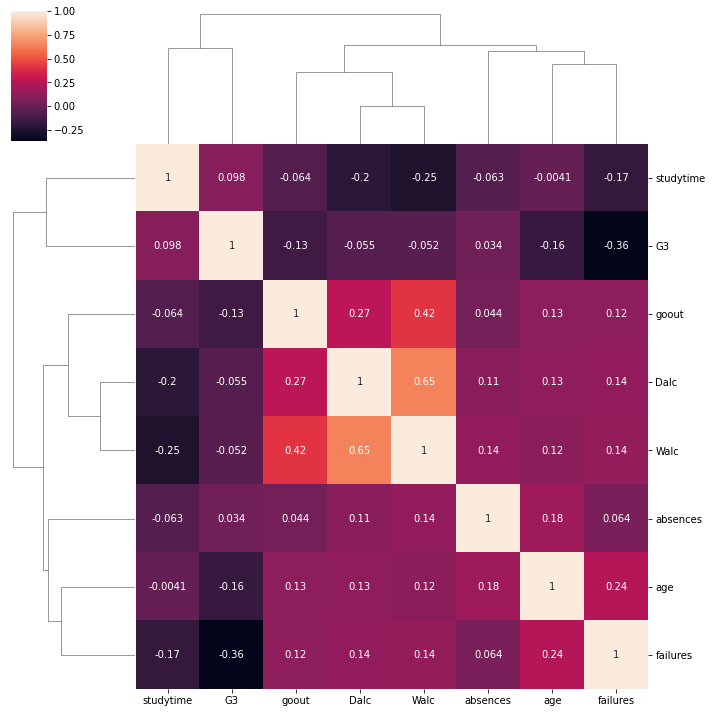

In [16]:
_= sns.clustermap(data=sml_feature_df.corr(), annot=True)

**As we can see, no big correlation here which is good!**

## Let's see if we can build a good Linear Regression model on the small feature dataset

In [17]:
sml_feature_df[:5]

,sex,age,studytime,failures,goout,Dalc,Walc,absences,G3
0,F,18,2,0,4,1,1,6,6
1,F,17,2,0,3,1,1,4,6
2,F,15,2,3,2,2,3,10,10
3,F,15,3,0,2,1,1,2,15
4,F,16,2,0,2,1,2,4,10


In [18]:
feature_cols = ['age', 'studytime', 'failures', 'goout', 'Dalc', 'Walc', 'absences']
X = sml_feature_df[feature_cols]
y = sml_feature_df['G3']

I don't think there is a point in normalizing the data, it is all very similar in value

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(f'MSE error: {mean_squared_error(y_test, y_pred)}')
print(f'r^2 score: {r2_score(y_test, y_pred)}')

MSE error: 24.597125856592157
r^2 score: 0.13109328407319654


## That is a pretty bad model! LOL
### Let's see if normalizing the data will help! 

In [20]:
from sklearn.preprocessing import normalize

X_norm = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm,y, test_size=.25, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(f'MSE error: {mean_squared_error(y_test, y_pred)}')
print(f'r^2 score: {r2_score(y_test, y_pred)}')

MSE error: 23.431019388434272
r^2 score: 0.17228662298504827


## Ok well, it improved a little bit, but not by that much!  
Let's see if giving it more features will help!
Let's also encode the non-numerical features!

In [21]:
big_feature_df = df[feature_cols_big]
big_feature_df[:5]

,sex,age,studytime,failures,goout,Dalc,Walc,absences,romantic,famrel,health,G1,G2,G3
0,F,18,2,0,4,1,1,6,no,4,3,5,6,6
1,F,17,2,0,3,1,1,4,no,5,3,5,5,6
2,F,15,2,3,2,2,3,10,no,4,3,7,8,10
3,F,15,3,0,2,1,1,2,yes,3,5,15,14,15
4,F,16,2,0,2,1,2,4,no,4,5,6,10,10


In [22]:
big_feature_df = pd.get_dummies(big_feature_df)
big_feature_df[:5]

,age,studytime,failures,goout,Dalc,Walc,absences,famrel,health,G1,G2,G3,sex_F,sex_M,romantic_no,romantic_yes
0,18,2,0,4,1,1,6,4,3,5,6,6,1,0,1,0
1,17,2,0,3,1,1,4,5,3,5,5,6,1,0,1,0
2,15,2,3,2,2,3,10,4,3,7,8,10,1,0,1,0
3,15,3,0,2,1,1,2,3,5,15,14,15,1,0,0,1
4,16,2,0,2,1,2,4,4,5,6,10,10,1,0,1,0


In [23]:
y = big_feature_df['G3']
X = big_feature_df.drop(['G3', 'G2', 'G1'], axis=1)

In [24]:
X_norm = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm,y, test_size=.25, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(f'MSE error: {mean_squared_error(y_test, y_pred)}')
print(f'r^2 score: {r2_score(y_test, y_pred)}')

MSE error: 21.8997194674222
r^2 score: 0.22638061726808256


## A little better.. But ehhh. Maybe there just isnt a good correlation between these features and the final numerical grade..

## Let's at least try PCA to see if we can improve the model even more!
This way we can reduce the number of features just to 2 or 3, instead of 11

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_red = pca.fit_transform(X_norm)
X_red[:2]

X_train, X_test, y_train, y_test = train_test_split(X_red,y, test_size=.25, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(f'MSE error: {mean_squared_error(y_test, y_pred)}')
print(f'r^2 score: {r2_score(y_test, y_pred)}')

MSE error: 27.85960790687035
r^2 score: 0.01584434886812547


## Well... that definetly did not make it any better :)

## Let's see if we can now classify students into pass/fail groups and see if we can build a better classification model than the linear regression one! 

In [26]:
big_feature_df = df[feature_cols_big]
big_feature_df = big_feature_df.drop(['G1', 'G2'], axis=1)
big_feature_df = pd.get_dummies(big_feature_df)
big_feature_df[:5]

,age,studytime,failures,goout,Dalc,Walc,absences,famrel,health,G3,sex_F,sex_M,romantic_no,romantic_yes
0,18,2,0,4,1,1,6,4,3,6,1,0,1,0
1,17,2,0,3,1,1,4,5,3,6,1,0,1,0
2,15,2,3,2,2,3,10,4,3,10,1,0,1,0
3,15,3,0,2,1,1,2,3,5,15,1,0,0,1
4,16,2,0,2,1,2,4,4,5,10,1,0,1,0


## Let's say that if G3 is >= 10 the person is passing, but if < 10 person is failing

In [27]:
big_feature_df['result'] = [1 if v >= 10 else 0 for v in big_feature_df['G3']]
big_feature_df[:1]

,age,studytime,failures,goout,Dalc,Walc,absences,famrel,health,G3,sex_F,sex_M,romantic_no,romantic_yes,result
0,18,2,0,4,1,1,6,4,3,6,1,0,1,0,0


In [28]:
big_feature_df['result'].value_counts()

1    265
0    130
Name: result, dtype: int64

## Let's start with SVM (Support Vector Machine)

## First we want to get the best hyper parameters using Grid Search

In [29]:
y = big_feature_df['result']
X = big_feature_df.drop(['G3', 'result'], axis=1)
X_norm = normalize(X)

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

svc_param_selection(X_norm, y, 5)

{'C': 10, 'gamma': 0.001}

**Perfect! Now we can use 10 as our C parameters for best results!**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.25, random_state=2)

svm_clf = svm.SVC(kernel='linear', C=10)

Since we are now doing classification problems, we can use the confusion matrix to calculate things like accuracy, recall and f1 score. But we can also use cross validation to see how good our model is! 

In [32]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator=svm_clf, X=X_norm, y=y, cv=5, scoring='accuracy')
mean_accuracy = accuracies.mean()

print(f'All accuracies: {accuracies}')
print(f'Mean accuracy: {mean_accuracy}')

f1_scores = cross_val_score(estimator=svm_clf, X=X_norm, y=y, cv=5, scoring='f1')
mean_f1_score = f1_scores.mean()

print(f'All f1 scores: {f1_scores}')
print(f'Mean f1 score: {mean_f1_score}')

All accuracies: [0.70886076 0.78481013 0.6835443  0.69620253 0.6835443 ]
Mean accuracy: 0.7113924050632912
All f1 scores: [0.81889764 0.85470085 0.80314961 0.81538462 0.80314961]
Mean f1 score: 0.8190564640958342


**Hmm.. This looks like a pretty good model! F1 score is pretty high, but accuracy is average..**

In [33]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
c_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion matrix:\n{c_matrix}')
print(f'Recall score: {recall_score(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1_score: {f1_score(y_test, y_pred)}')

Confusion matrix:
[[ 8 22]
 [ 2 67]]
Recall score: 0.9710144927536232
Accuracy: 0.7575757575757576
F1_score: 0.8481012658227848


Ok... So we are getting a lot of False Positives, which means that when the student actually did not pass, we are saying that he/she did. I guess this is not critical, it would be worse if the student passed and we would have been saying that they didnt...

## Let's try PCA and see what happens, do some dimensionality REDUCTION!

In [34]:
pca = PCA(n_components=2)
X_red = pca.fit_transform(X_norm)

In [35]:
pca_df = pd.DataFrame(X_red, columns=['pca1', 'pca2'])
pca_df['pass'] = ['+' if v == 1 else '-' for v in y]
pca_df[:1]

,pca1,pca2,pass
0,0.038789,-0.06692,-


In [36]:
alt.Chart(pca_df).mark_circle(size=60).encode(
    x='pca1',
    y='pca2',
    color=alt.Color('pass', legend=alt.Legend(title="pass/no-pass"))
)

alt.Chart(...)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=.25, random_state=2)
svm_clf = svm.SVC(kernel='linear', C=10)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
c_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion matrix:\n{c_matrix}')
print(f'Recall score: {recall_score(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1_score: {f1_score(y_test, y_pred)}')

Confusion matrix:
[[ 0 30]
 [ 0 69]]
Recall score: 1.0
Accuracy: 0.696969696969697
F1_score: 0.8214285714285715


For some reason we are not getting any false/true negatives at all... Interesting.. But accuracy of model went down by a decent amount, and f1 score also went down... So probably not a good idea to use PCA in this case

## Let's try building a decision tree!

In [38]:
big_feature_df[:1]

,age,studytime,failures,goout,Dalc,Walc,absences,famrel,health,G3,sex_F,sex_M,romantic_no,romantic_yes,result
0,18,2,0,4,1,1,6,4,3,6,1,0,1,0,0


In [39]:
from sklearn.tree import DecisionTreeClassifier

y = big_feature_df['result']
X = big_feature_df.drop(['G3', 'result'], axis=1)

X_norm = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.25, random_state=0)

d_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [40]:
accuracies = cross_val_score(estimator=d_tree, X=X_norm, y=y, cv=5, scoring='accuracy')
mean_accuracy = accuracies.mean()

print(f'All accuracies: {accuracies}')
print(f'Mean accuracy: {mean_accuracy}')

f1_scores = cross_val_score(estimator=d_tree, X=X_norm, y=y, cv=5, scoring='f1')
mean_f1_score = f1_scores.mean()

print(f'All f1 scores: {f1_scores}')
print(f'Mean f1 score: {mean_f1_score}')

All accuracies: [0.59493671 0.58227848 0.59493671 0.63291139 0.63291139]
Mean accuracy: 0.6075949367088608
All f1 scores: [0.72131148 0.69230769 0.67307692 0.75728155 0.7184466 ]
Mean f1 score: 0.7124848492268516


## A little bit worse than SVM

In [41]:
from sklearn.metrics import accuracy_score, f1_score

d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)

print(f'Confusion matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'F1 score: {f1_score(y_test, y_pred)}')

Confusion matrix:
 [[13 24]
 [16 46]]
Accuracy score: 0.5959595959595959
F1 score: 0.6969696969696969


## Let's visualize this decision tree!

In [42]:
from dtreeviz.trees import *

In [43]:
X_sample = np.array(X_norm[np.random.randint(0, X_norm.shape[0]),:])
feature_names = X.columns
class_names = [0, 1]

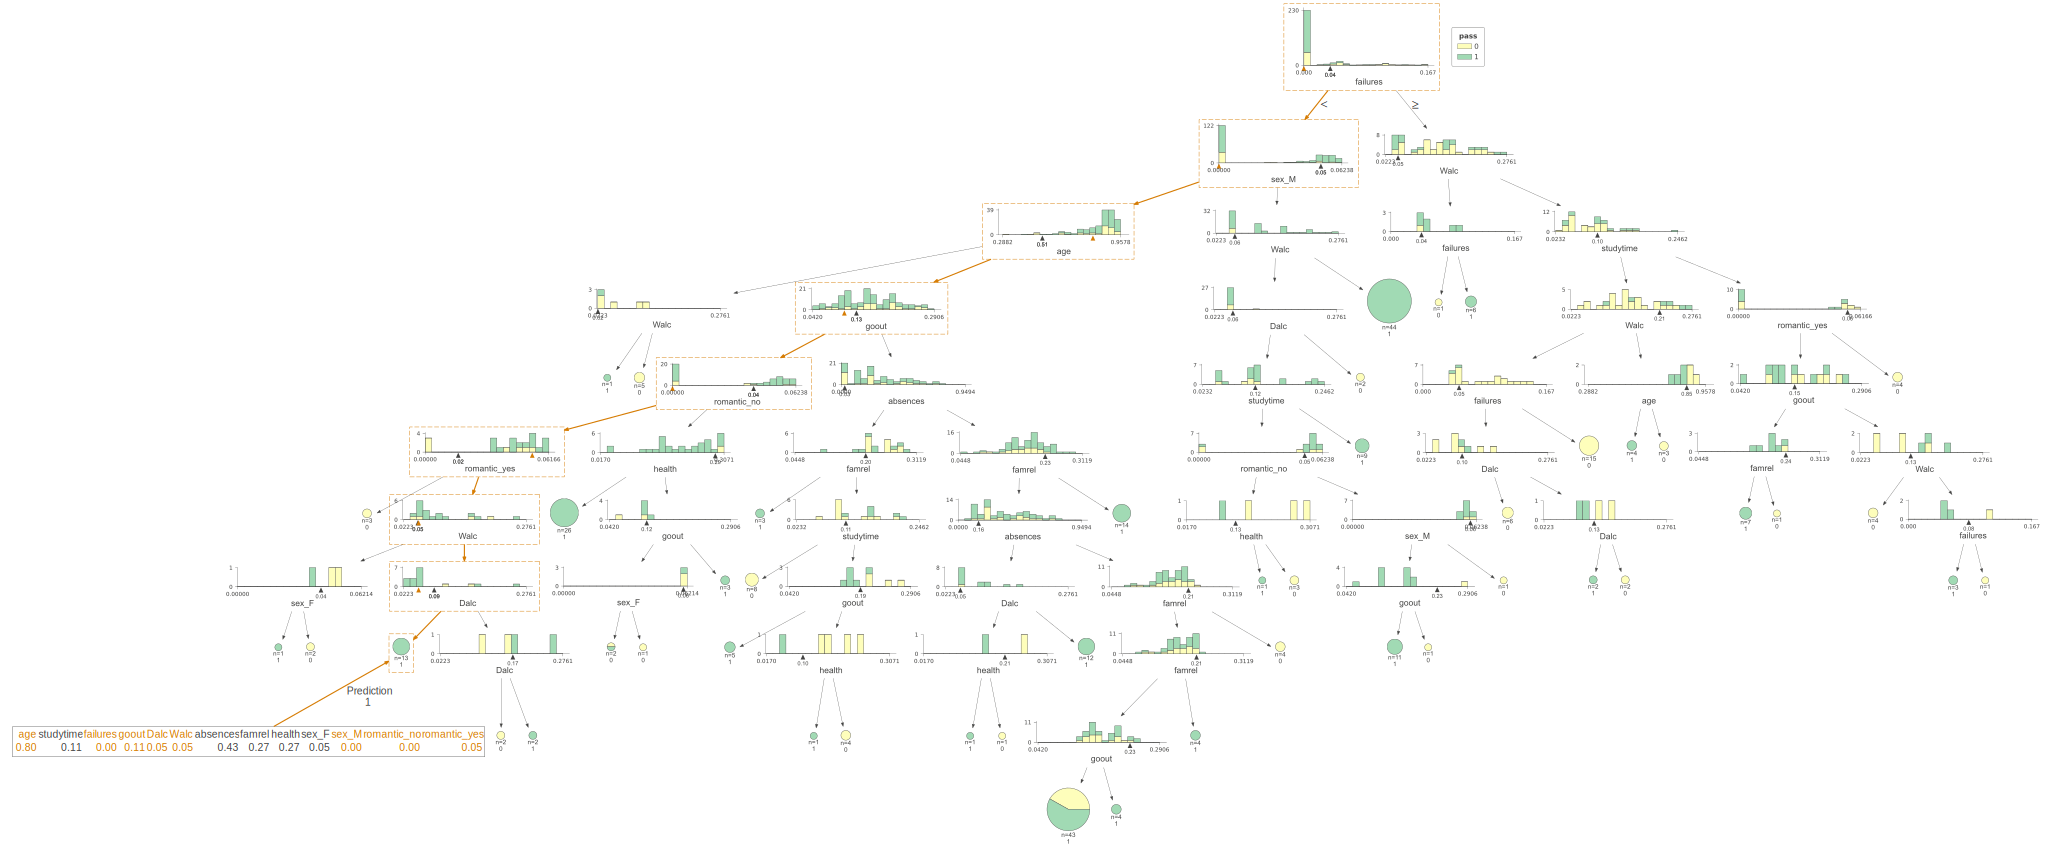

In [44]:
viz = dtreeviz(d_tree,
               X_train,
               y_train,
               target_name='pass',  # this name will be displayed at the leaf node
               class_names=class_names,
               feature_names=feature_names,
               X=X_sample
              )

viz

## Let's see if reducing depth can increase our accuracy and f1 score!

In [45]:
d_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)

accuracies = cross_val_score(estimator=d_tree, X=X_norm, y=y, cv=5, scoring='accuracy')
mean_accuracy = accuracies.mean()

print(f'All accuracies: {accuracies}')
print(f'Mean accuracy: {mean_accuracy}')

f1_scores = cross_val_score(estimator=d_tree, X=X_norm, y=y, cv=5, scoring='f1')
mean_f1_score = f1_scores.mean()

print(f'All f1 scores: {f1_scores}')
print(f'Mean f1 score: {mean_f1_score}')

All accuracies: [0.65822785 0.6835443  0.64556962 0.65822785 0.62025316]
Mean accuracy: 0.6531645569620252
All f1 scores: [0.77419355 0.77876106 0.76666667 0.74285714 0.7       ]
Mean f1 score: 0.7524956839715617


## That made it better! 

In [46]:
d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)

print(f'Confusion matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'F1 score: {f1_score(y_test, y_pred)}')

Confusion matrix:
 [[18 19]
 [13 49]]
Accuracy score: 0.6767676767676768
F1 score: 0.7538461538461538


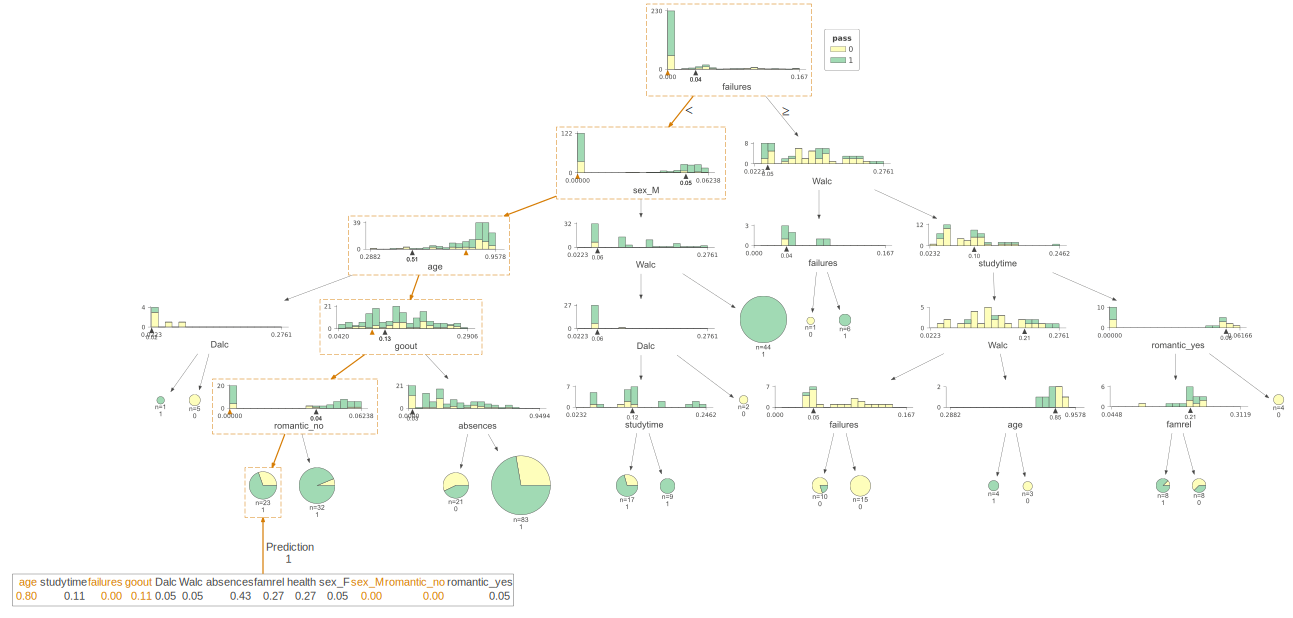

In [47]:
dtreeviz(d_tree,
       X_train,
       y_train,
       target_name='pass',  # this name will be displayed at the leaf node
       class_names=class_names,
       feature_names=feature_names,
       X=X_sample
      )

## Now let's try to build a random forest tree to figure out what feature affects student's grades the most

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'F1_score: {f1_score(y_test, y_pred)}')

Confusion matrix: 
[[13 24]
 [ 3 59]]
Accuracy score: 0.7272727272727273
F1_score: 0.8137931034482758


## Now thats a pretty decent model, not great... But still decent!

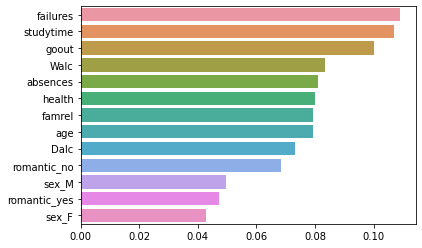

In [49]:
feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
_= sns.barplot(x=feature_imp, y=feature_imp.index)

# Conclusions

## Regression
- Did not work so well for this dataset.. Oh well
- PCA made everything worse

**Linear Regression**:
> **MSE:** 21.89  
**r^2 score:** 0.23

## Classification
- Grouped students into pass/fail based on final grade -> pass if G3 >= 10, fail if G3 < 10  

**SVM**:
> **Accuracy:** 0.75  
**F1_score:** 0.85  

**Decision Tree**:
> **Accuracy score:** 0.61   
**F1 score:** 0.71

**Random Forest Tree**:
> **Accuracy score:** 0.74  
**F1_score:** 0.82